# Data Preprocessing

## Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy.fft import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Extract Taichung and Shitun

In [3]:
raw = pd.read_csv('file.csv')
raw['Date'] = pd.to_datetime(raw["DataCreationDate"], format = "%Y-%m-%d %H:%M")
raw = raw.set_index(['Date'])
raw.columns

/Users/chen_yenru/opt/anaconda3/envs/tflearn/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6,7,8,9,10,14,15,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['SiteName', 'County', 'AQI', 'Pollutant', 'Status', 'SO2', 'CO', 'O3',
       'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed', 'WindDirec',
       'DataCreationDate', 'Unit', 'CO_8hr', 'PM2.5_AVG', 'PM10_AVG',
       'SO2_AVG', 'Longitude', 'Latitude', 'SiteId'],
      dtype='object')

### Get Taichung's data

In [4]:
raw = raw[['SiteName', "DataCreationDate", "AQI", "County"]]

mask = (raw['County'] == "臺中市") & (raw['SiteName']!='崇倫') & (raw['SiteName']!= "行動監測03")
data = raw[mask]
data["AQI"] = data["AQI"].fillna(0)

/var/folders/0y/bnh8rvg11rd93vjf0f787p980000gn/T/ipykernel_19230/4251703891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["AQI"] = data["AQI"].fillna(0)


### Data Inspection

In [5]:
data.head()

,SiteName,DataCreationDate,AQI,County
Date,,,,
2016-11-25 13:00:00,豐原,2016-11-25 13:00,23.0,臺中市
2016-11-25 13:00:00,沙鹿,2016-11-25 13:00,21.0,臺中市
2016-11-25 13:00:00,大里,2016-11-25 13:00,25.0,臺中市
2016-11-25 13:00:00,忠明,2016-11-25 13:00,23.0,臺中市
2016-11-25 13:00:00,西屯,2016-11-25 13:00,24.0,臺中市


DatetimeIndex(['2016-11-25 13:00:00', '2016-11-25 14:00:00',
               '2016-11-25 18:00:00', '2016-11-25 15:00:00',
               '2016-11-25 16:00:00', '2016-11-25 19:00:00',
               '2016-11-25 17:00:00', '2016-11-25 20:00:00',
               '2016-11-25 21:00:00', '2016-11-25 22:00:00',
               ...
               '2021-12-31 23:00:00', '2021-12-31 11:00:00',
               '2021-12-31 12:00:00', '2021-12-31 13:00:00',
               '2021-12-31 14:00:00', '2021-12-31 15:00:00',
               '2021-12-31 16:00:00', '2021-12-31 17:00:00',
               '2021-12-31 18:00:00', '2021-12-31 19:00:00'],
              dtype='datetime64[ns]', name='Date', length=44025, freq=None)


<AxesSubplot:xlabel='Date'>

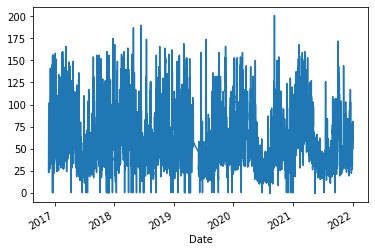

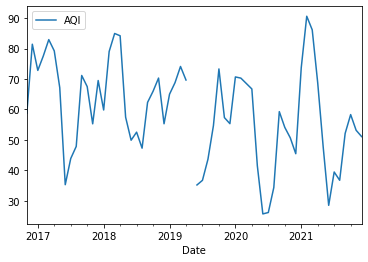

In [6]:
mask_shi = data['SiteName']=='西屯'
shitun = data[mask_shi]

# td = shitun.set_index(pd.DatetimeIndex(pd.to_datetime(shitun["DataCreationDate"], format = "%Y-%m-%d %H:%M")))
print(shitun.index)
shitun["AQI"].plot()
tdm = shitun.resample('M').mean()
tdm.plot()

In [10]:
"""Failed attempt on data"""
# td = data.set_index(pd.DatetimeIndex(pd.to_datetime(data["DataCreationDate"], format = "%Y-%m-%d %H:%M")))
# print(data.index.max())
# #td.resample('M').sum().plot()
# ax,fig = plt.subplots(figsize=(20, 20))
# td['mon'] = td.groupby(td.index.month)['AQI'].transform('mean')
# td['mon']
# td.groupby('SiteName')['AQI'].plot(legend=True)
# td.resample('M').sum().plot()

'Failed attempt on data'

In [7]:
shitun.to_csv("shitun.csv")

## Smoothing

### Exponential Weighted Mean

<AxesSubplot:xlabel='Date'>

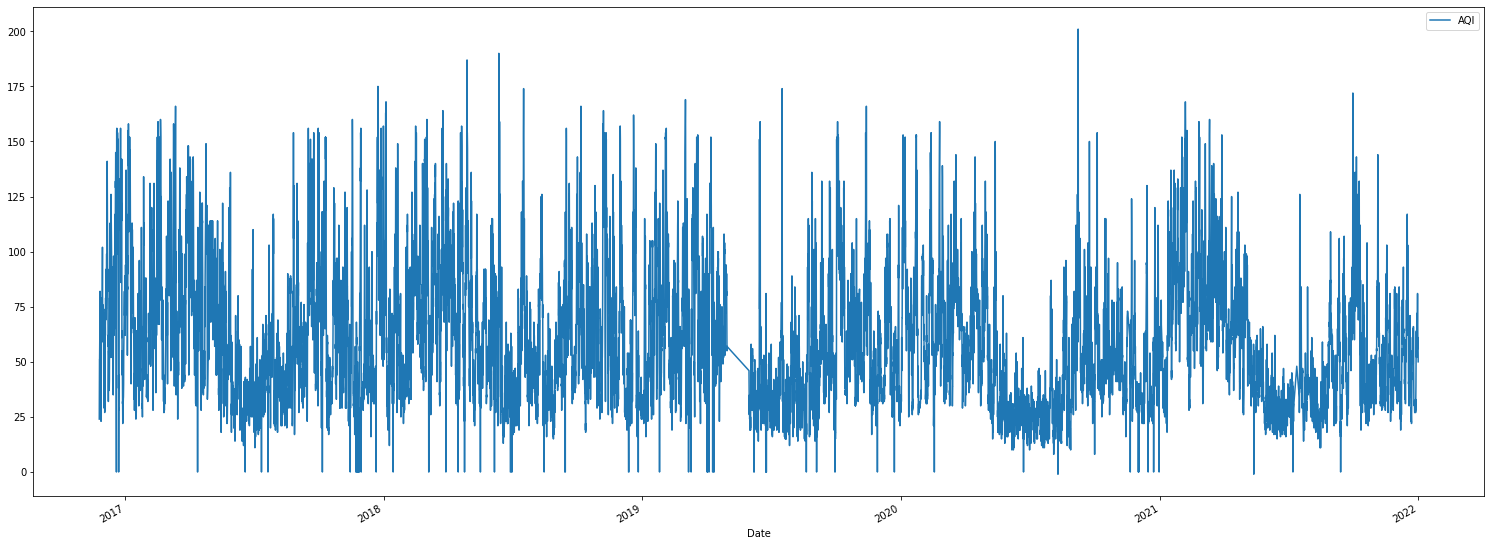

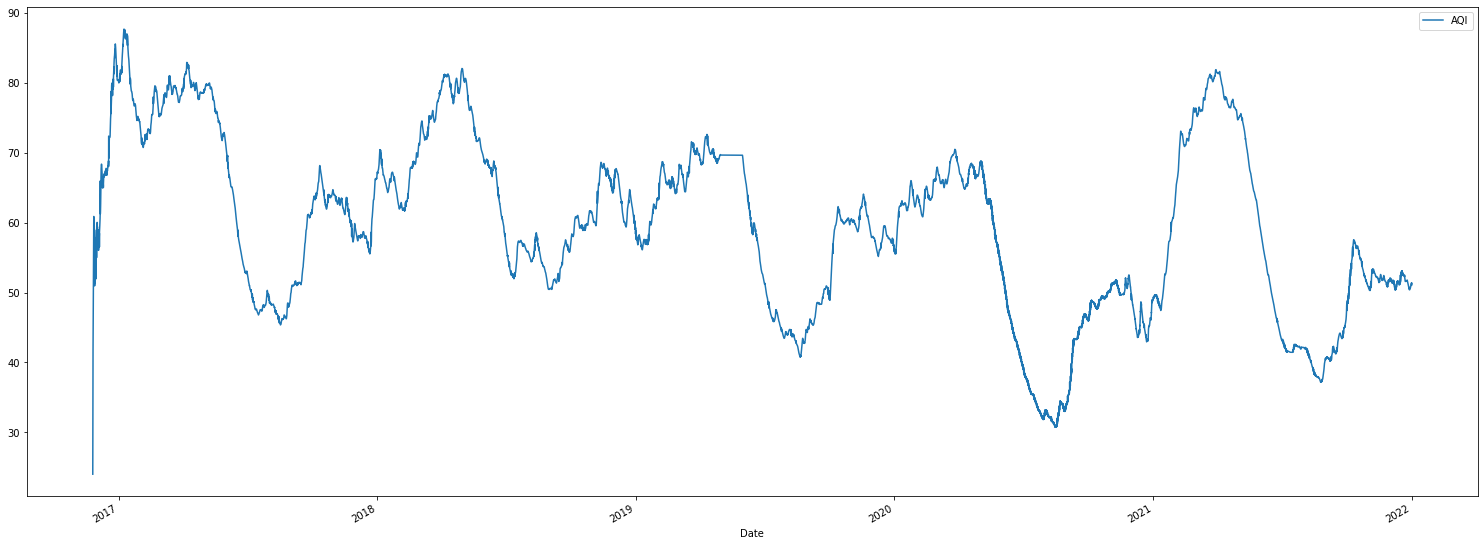

In [11]:
shitun.plot(figsize=(26,10))
shitun.ewm(1000).mean().plot(figsize=(26,10))

### Fourier Transform (FFT) + Exponential Weighted Mean (EWM)

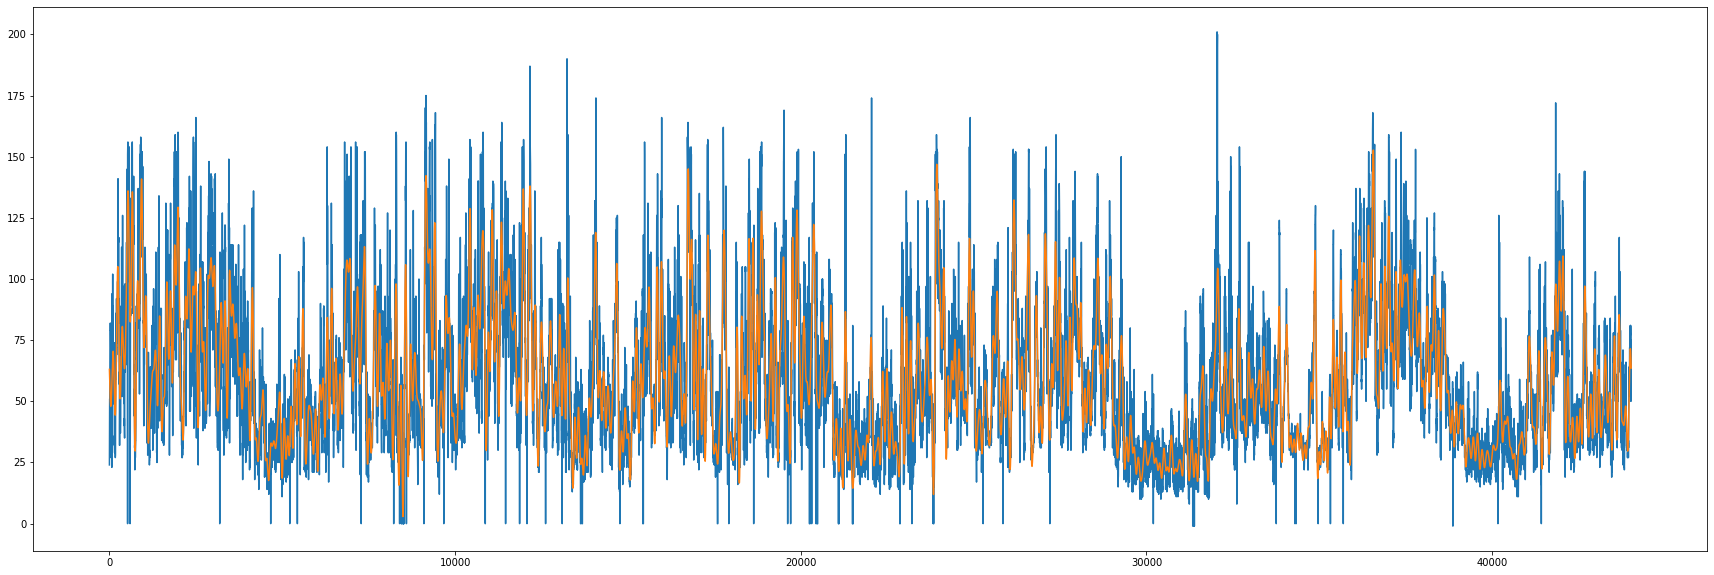

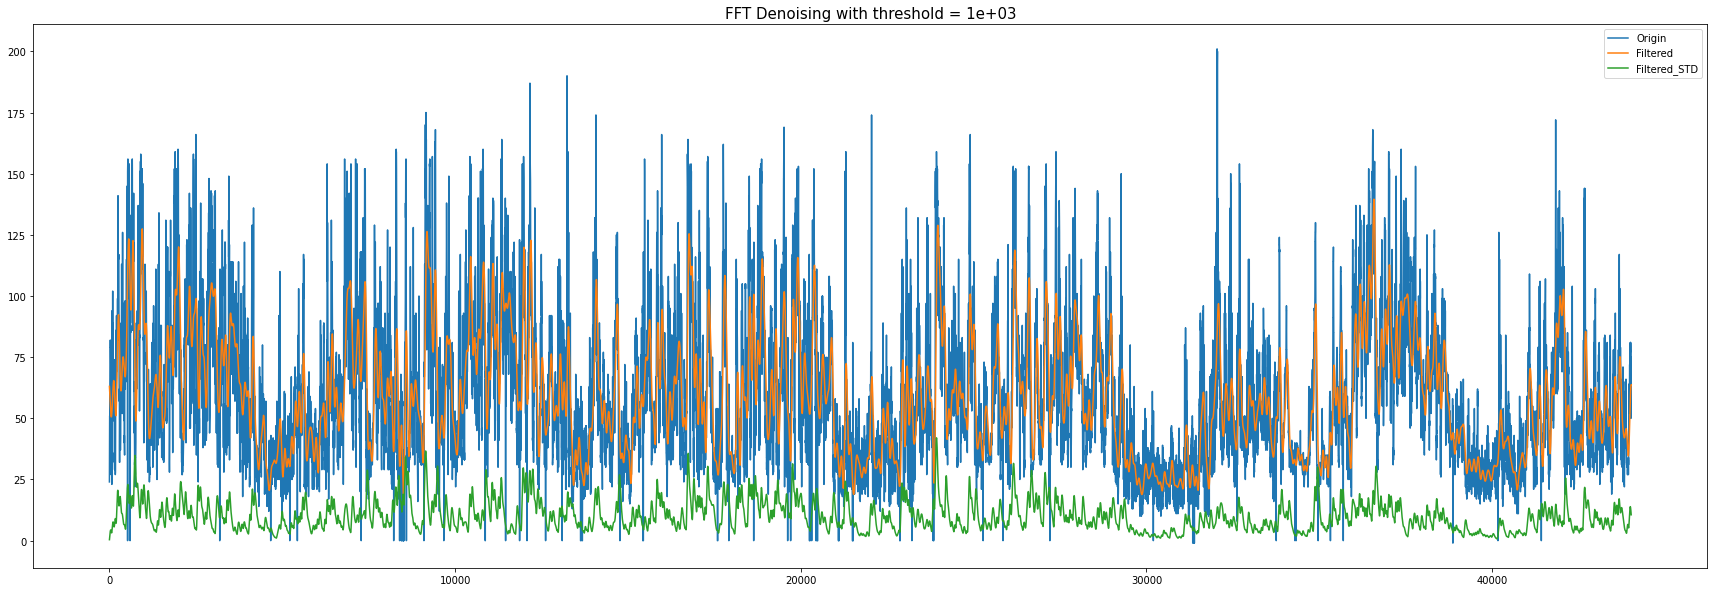

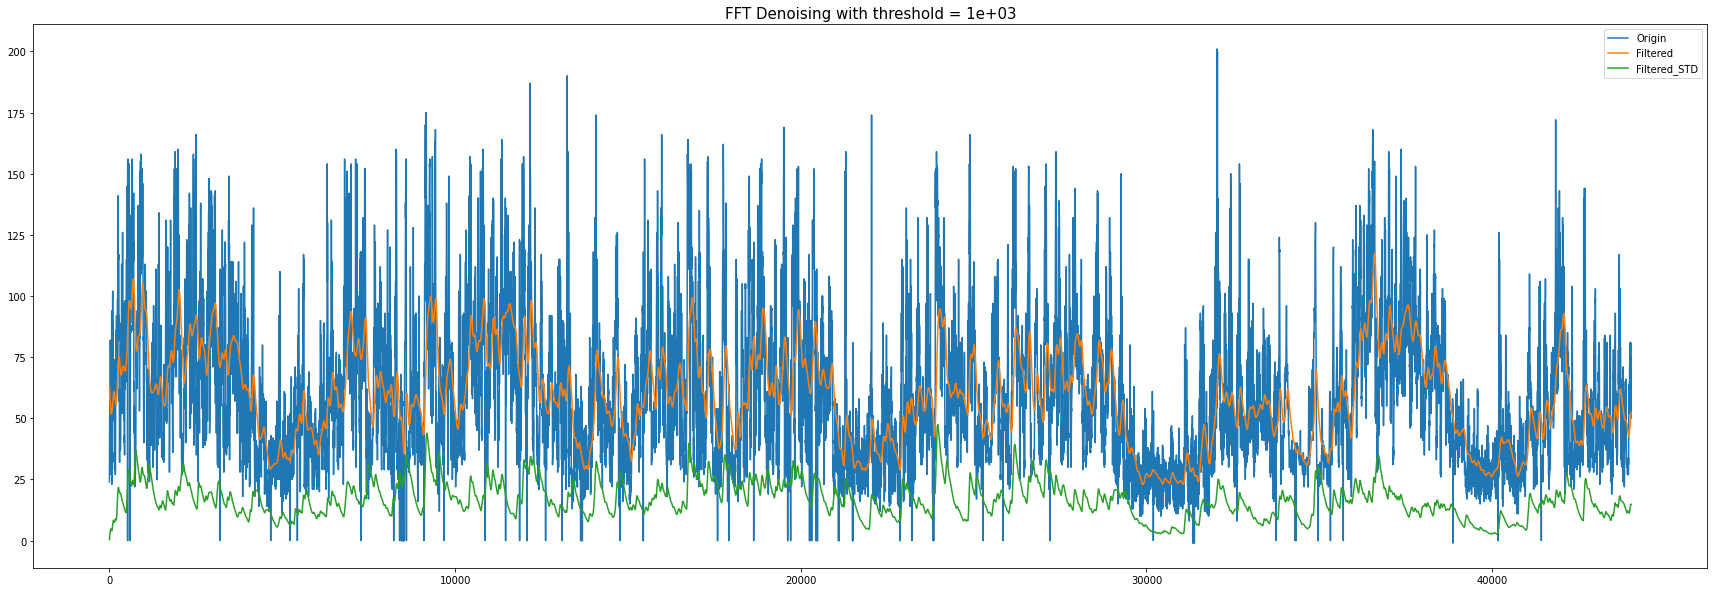

In [12]:
def filter_signal(signal, threshold):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=1e-5)
    fourier[frequencies > threshold] = 0
    return pd.DataFrame(irfft(fourier))


THRESHOLD = 1e3
origin = shitun['AQI'].values
signal = filter_signal(shitun['AQI'].values, threshold=THRESHOLD)

signal_ewm = signal.ewm(30).mean()
signal_ewm_std = signal.ewm(30).std()

signal_ewm_31 = signal.ewm(120).mean()
signal_ewm_std_31 = signal.ewm(120).std()



#filtered = filter_signal(signal, threshold=THRESHOLD)
plt.figure(figsize=(30, 10))
plt.plot(origin, label='Origin')
plt.plot(signal, label='Raw')
plt.show()

plt.figure(figsize=(30, 10))
plt.plot(origin, label='Origin')
plt.plot(signal_ewm, label='Filtered')
plt.plot(signal_ewm_std, label='Filtered_STD')
plt.legend()
plt.title(f"FFT Denoising with threshold = {THRESHOLD:.0e}", size=15)
plt.show()

plt.figure(figsize=(30, 10))
plt.plot(origin, label='Origin')
plt.plot(signal_ewm_31, label='Filtered')
plt.plot(signal_ewm_std_31, label='Filtered_STD')
plt.legend()
plt.title(f"FFT Denoising with threshold = {THRESHOLD:.0e}", size=15)
plt.show()
# for threshold in [1e3, 5e3, 1e4, 5e4]:
#     filtered = filter_signal(signal, threshold=threshold)

#     plt.figure(figsize=(30, 10))
#     plt.plot(signal, label='Raw')
#     plt.plot(filtered, label='Filtered')
#     plt.legend()
#     plt.title(f"FFT Denoising with threshold = {threshold :.0e}", size=15)
#     plt.show()

### Add new columns with EWM+FFT Smoothing's AQI values

In [13]:
shitun["AQI"].size

44025

In [14]:
"""makes the size of the signal_ewm_31 fit with shitun"""
signal_ewm_31.loc[-1] = signal_ewm_31[0]  # adding a row
signal_ewm_31.index = signal_ewm_31.index + 1  # shifting index
signal_ewm_31 = signal_ewm_31.sort_index()  # sorting by index


In [15]:
shitun.index

DatetimeIndex(['2016-11-25 13:00:00', '2016-11-25 14:00:00',
               '2016-11-25 18:00:00', '2016-11-25 15:00:00',
               '2016-11-25 16:00:00', '2016-11-25 19:00:00',
               '2016-11-25 17:00:00', '2016-11-25 20:00:00',
               '2016-11-25 21:00:00', '2016-11-25 22:00:00',
               ...
               '2021-12-31 23:00:00', '2021-12-31 11:00:00',
               '2021-12-31 12:00:00', '2021-12-31 13:00:00',
               '2021-12-31 14:00:00', '2021-12-31 15:00:00',
               '2021-12-31 16:00:00', '2021-12-31 17:00:00',
               '2021-12-31 18:00:00', '2021-12-31 19:00:00'],
              dtype='datetime64[ns]', name='Date', length=44025, freq=None)

In [16]:
signal_ewm_31[0].values

array([63.05336985, 63.05336985, 62.77692849, ..., 52.32319527,
       52.42079983, 52.51316786])

In [17]:
shitun["AQI31"] = signal_ewm_31[0].values

/var/folders/0y/bnh8rvg11rd93vjf0f787p980000gn/T/ipykernel_17606/3431609016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shitun["AQI31"] = signal_ewm_31[0].values


In [18]:
shitun.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44025 entries, 2016-11-25 13:00:00 to 2021-12-31 19:00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SiteName          44025 non-null  object 
 1   DataCreationDate  44025 non-null  object 
 2   AQI               44025 non-null  float64
 3   County            44025 non-null  object 
 4   AQI31             44025 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


#### Plotting AQI and AQI31

<AxesSubplot:xlabel='Date'>

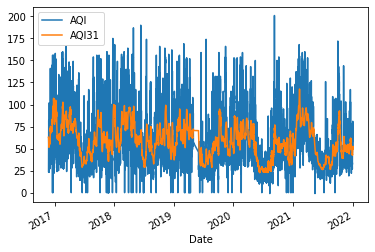

In [19]:
shitun.plot()

# Merge Data

## Number of Cars

In [63]:
"""Function to combine data"""
def to_month(file_path):
    raw = pd.read_csv(file_path, thousands=',')
    raw["Date"] = pd.to_datetime(raw["Date"], format='%Y')
    raw = raw.set_index("Date")
    c0 = raw.index > '2015-01-01'
    raw = raw[c0]

    raw = raw.resample('M').bfill()
    raw = raw[:-1]

    print("Plot of the input file")
    raw.plot()

    return raw
    
    

## Functional Approach (Unorganized)

Plot of the input file
Empty DataFrame
Columns: [index, Date, SiteName, DataCreationDate, AQI, County, AQI31, Number of Cars_x, Number of Cars_y, Number of Cars]
Index: []


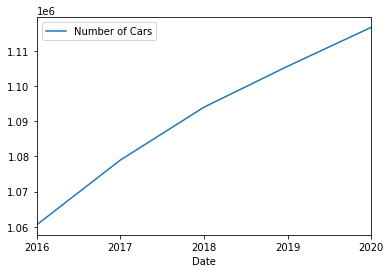

In [62]:
tch_cars = combine(shitun, 'tch_cars.csv')

In [18]:
# tch_cars = pd.read_csv("tch_cars.csv", thousands=',')
# tch_cars.head()
# tch_cars.append({"Date":2021, "Number of Cars":1127084}, ignore_index=True)

In [19]:
tch_cars["Date"] = pd.to_datetime(tch_cars["Date"], format='%Y')
tch_cars = tch_cars.set_index("Date")

In [20]:
tch_cars.index

tch_cars.loc['2022-01-01', 'Number of Cars'] = 1127084

In [21]:
c0 = tch_cars.index > '2015-01-01'
tch_cars = tch_cars[c0]

In [22]:
tch_cars

,SiteName,DataCreationDate,AQI,County,AQI31,Number of Cars
Date,,,,,,
2016-11-30,西屯,2016-11-30 00:00,99.0,臺中市,55.999802,1078943.0
2016-12-31,西屯,2016-12-31 00:00,82.0,臺中市,79.846730,1078943.0
2017-01-31,西屯,2017-01-31 00:00,44.0,臺中市,63.982953,1093995.0
2017-02-28,西屯,2017-02-28 00:00,69.0,臺中市,64.922719,1093995.0
2017-03-31,西屯,2017-03-31 00:00,146.0,臺中市,77.674272,1093995.0
2017-05-31,西屯,2017-05-31 00:00,36.0,臺中市,64.580324,1093995.0
2017-06-30,西屯,2017-06-30 00:00,55.0,臺中市,37.667652,1093995.0
2017-07-31,西屯,2017-07-31 00:00,26.0,臺中市,57.014508,1093995.0
2017-08-31,西屯,2017-08-31 00:00,81.0,臺中市,56.684077,1093995.0


<AxesSubplot:xlabel='Date'>

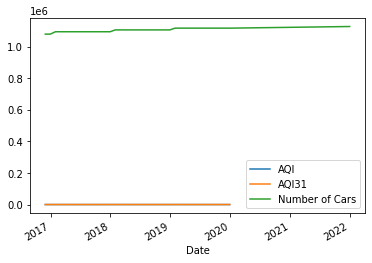

In [23]:
tch_cars.plot()

In [24]:
tch_cars = tch_cars.resample('M').bfill()

In [25]:
tch_cars = tch_cars[:-1]

In [26]:
new = shitun.merge(tch_cars, left_index=True, right_index=True, how='inner')

In [27]:
tch_cars

,SiteName,DataCreationDate,AQI,County,AQI31,Number of Cars
Date,,,,,,
2016-11-30,西屯,2016-11-30 00:00,99.0,臺中市,55.999802,1078943.0
2016-12-31,西屯,2016-12-31 00:00,82.0,臺中市,79.846730,1078943.0
2017-01-31,西屯,2017-01-31 00:00,44.0,臺中市,63.982953,1093995.0
2017-02-28,西屯,2017-02-28 00:00,69.0,臺中市,64.922719,1093995.0
2017-03-31,西屯,2017-03-31 00:00,146.0,臺中市,77.674272,1093995.0
...,...,...,...,...,...,...
2021-08-31,NaN,NaN,NaN,NaN,NaN,1127084.0
2021-09-30,NaN,NaN,NaN,NaN,NaN,1127084.0
2021-10-31,NaN,NaN,NaN,NaN,NaN,1127084.0


In [28]:
new = new.reset_index()

In [29]:
new.head()

,Date,SiteName_x,DataCreationDate_x,AQI_x,County_x,AQI31_x,SiteName_y,DataCreationDate_y,AQI_y,County_y,AQI31_y,Number of Cars
0,2016-11-30,西屯,2016-11-30 00:00,99.0,臺中市,55.999802,西屯,2016-11-30 00:00,99.0,臺中市,55.999802,1078943.0
1,2016-12-31,西屯,2016-12-31 00:00,82.0,臺中市,79.846730,西屯,2016-12-31 00:00,82.0,臺中市,79.846730,1078943.0
2,2017-01-31,西屯,2017-01-31 00:00,44.0,臺中市,63.982953,西屯,2017-01-31 00:00,44.0,臺中市,63.982953,1093995.0
3,2017-02-28,西屯,2017-02-28 00:00,69.0,臺中市,64.922719,西屯,2017-02-28 00:00,69.0,臺中市,64.922719,1093995.0
4,2017-03-31,西屯,2017-03-31 00:00,146.0,臺中市,77.674272,西屯,2017-03-31 00:00,146.0,臺中市,77.674272,1093995.0


In [30]:
new["Number of Cars"]

0     1078943.0
1     1078943.0
2     1093995.0
3     1093995.0
4     1093995.0
        ...    
56    1127084.0
57    1127084.0
58    1127084.0
59    1127084.0
60    1127084.0
Name: Number of Cars, Length: 61, dtype: float64

In [32]:
sns.scatterplot(x=new["Number of Cars"], y=new["AQI"])

KeyError: 'AQI'

In [ ]:
sns.scatterplot(x=new["AQI"], y=new["Number of Cars"])

In [ ]:
sns.lineplot(x=new["Number of Cars"], y=new["AQI"])

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x1 = new.index.values
y1 = new["AQI"]
z1 = new["Number of Cars"]
ax.scatter(x1, y1, z1)

## Merge New Data

Plot of the input file


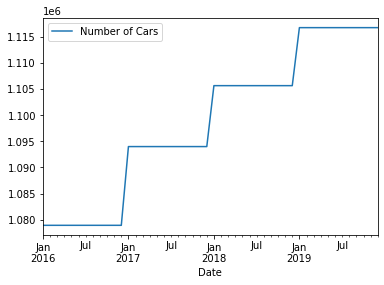

In [64]:
shitun_cars = to_month("tch_cars.csv")

Data to be merged:
1. 垃圾焚化量 **trash_burned.csv**
2. 垃圾車數量 **garbage_truck.csv**
3. 工廠密度 **factory_density.csv**


In [65]:
trash = pd.read_csv("trash_burned.csv", thousands=',')

In [66]:
trash

,Date,Trash Incineration Volume (tonnes)
0,2017,347813
1,2018,674180
2,2019,625129
3,2020,496727


Plot of the input file


<AxesSubplot:xlabel='Date'>

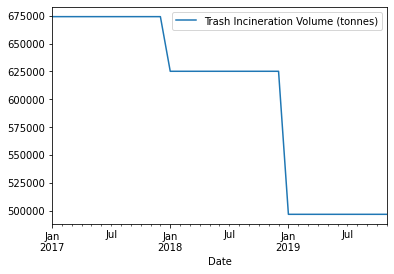

In [70]:
#trash["Date"] = pd.to_datetime(trash["Date"], format='%Y')
#trash = trash.set_index("Date")

trash = trash.resample('M').bfill()
trash = trash[:-1]

print("Plot of the input file")
trash.plot()

In [72]:
shitun_cars

,Number of Cars
Date,
2016-01-31,1078943.0
2016-02-29,1078943.0
2016-03-31,1078943.0
2016-04-30,1078943.0
2016-05-31,1078943.0
2016-06-30,1078943.0
2016-07-31,1078943.0
2016-08-31,1078943.0
2016-09-30,1078943.0


In [73]:
new = shitun_cars.merge(trash, left_index=True, right_index=True, how='inner')

In [74]:
new

,Number of Cars,Trash Incineration Volume (tonnes)
Date,,
2017-01-31,1093995.0,674180.0
2017-02-28,1093995.0,674180.0
2017-03-31,1093995.0,674180.0
2017-04-30,1093995.0,674180.0
2017-05-31,1093995.0,674180.0
2017-06-30,1093995.0,674180.0
2017-07-31,1093995.0,674180.0
2017-08-31,1093995.0,674180.0
2017-09-30,1093995.0,674180.0


In [75]:
new.to_csv('cars_and_trash')

,Number of Cars,Trash Incineration Volume (tonnes)
Date,,
2017-01-31,1093995.0,674180.0
2017-02-28,1093995.0,674180.0
2017-03-31,1093995.0,674180.0
2017-04-30,1093995.0,674180.0
2017-05-31,1093995.0,674180.0
2017-06-30,1093995.0,674180.0
2017-07-31,1093995.0,674180.0
2017-08-31,1093995.0,674180.0
2017-09-30,1093995.0,674180.0
